# **Cài đặt thư viện pytorch**

In [ ]:
!pip install torch torchvision timm

# **TẢI DỮ LIỆU VỀ**

In [ ]:
!curl -L "https://app.roboflow.com/ds/YPUYOwgVZ5?key=MYAPIKEY" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 extracting: train/G3-III/_8081_jpg.rf.0cd1dc2d6065738e62f9eeb5a5acf309.jpg  
 extracting: train/G3-III/_8081_jpg.rf.7b3032e93b90e071649521928d2762cd.jpg  
 extracting: train/G3-III/_8082_jpg.rf.4b999b340169d4ccff03a36f39753aec.jpg  
 extracting: train/G3-III/_8082_jpg.rf.6f05b0ac3ff4e5fccd15edec55ab5d7e.jpg  
 extracting: train/G3-III/_8083_jpg.rf.22c25ff5cd93fa0554941e2ed6cc5a15.jpg  
 extracting: train/G3-III/_8083_jpg.rf.e5da973978d5c8efe73dea7ad10fec4f.jpg  
 extracting: train/G3-III/_8088_jpg.rf.5aebb492fa310a2655646fe8b1cf7c20.jpg  
 extracting: train/G3-III/_8088_jpg.rf.76a3e25ebadaed73fc0205ffb5a04a7f.jpg  
 extracting: train/G3-III/_8091_jpg.rf.470ea21455e9abae96bdf665854146ae.jpg  
 extracting: train/G3-III/_8091_jpg.rf.b48b7223a0a2dfa083ee7bf4cca751cc.jpg  
 extracting: train/G3-III/_8092_jpg.rf.1a7318fd868ab8a2280a9427c7fced84.jpg  
 extracting: train/G3-III/_8092_jpg.rf.be54ca0deed7064c790b107e80ce1c05.jpg  
 extrac

# **CẤU HÌNH DỮ LIỆU**

In [ ]:
!pip install torch-lr-finder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from torch.utils.data import DataLoader

# 1. Chuẩn bị dữ liệu
data_dir = '/content'  # Thay đường dẫn này bằng đường dẫn đến thư mục gốc của dữ liệu
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'valid')  # Nếu bạn có tập validation riêng
test_dir = os.path.join(data_dir, 'test')


train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])  # Hoặc dùng mean/std của ImageNet
])

val_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
   transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])


# Tạo datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)

# Tạo dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# **Tạo model và tìm learning rate**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/421 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.81E-04


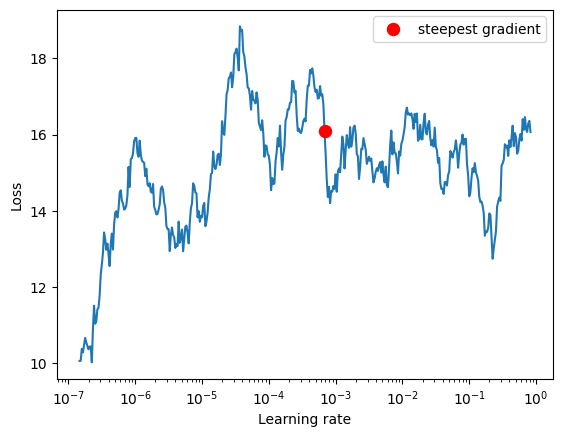

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.0006812920690579618)

In [ ]:
model = inception_v3(pretrained=True, aux_logits=True)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Cấu hình nhánh phụ auxiliary classifier
if model.aux_logits:
    num_ftrs_aux = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_ftrs_aux, num_classes)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Bọc mô hình
model.train()

# Khởi tạo lại optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

# Tìm learning rate
lr_finder = LRFinder(model_wrapped, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=1, num_iter=len(train_loader))
lr_finder.plot()


# **Cấu hình tham số huấn luyện**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from torchvision.models import Inception_V3_Weights

model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT, aux_logits=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

if model.aux_logits:
    num_ftrs_aux = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_ftrs_aux, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=6.81e-04, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, aux_outputs = model(inputs)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss_total = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):  # Nếu vẫn trả về tuple
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            val_loss_total += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss_total / len(val_loader)
    val_accuracy = correct / total * 100

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    scheduler.step(avg_val_loss)


Epoch 1, Train Loss: 1.1512, Val Loss: 0.7768, Val Acc: 74.28%
Epoch 2, Train Loss: 0.5236, Val Loss: 0.2307, Val Acc: 91.92%
Epoch 3, Train Loss: 0.3750, Val Loss: 0.3601, Val Acc: 87.91%
Epoch 4, Train Loss: 0.2935, Val Loss: 0.7789, Val Acc: 81.53%
Epoch 5, Train Loss: 0.2607, Val Loss: 0.1772, Val Acc: 94.75%
Epoch 6, Train Loss: 0.1929, Val Loss: 0.2360, Val Acc: 92.64%
Epoch 7, Train Loss: 0.1770, Val Loss: 0.1489, Val Acc: 95.01%
Epoch 8, Train Loss: 0.1629, Val Loss: 0.1123, Val Acc: 96.40%
Epoch 9, Train Loss: 0.1469, Val Loss: 0.1944, Val Acc: 94.08%
Epoch 10, Train Loss: 0.1546, Val Loss: 0.3275, Val Acc: 90.69%
Epoch 11, Train Loss: 0.1183, Val Loss: 0.1063, Val Acc: 96.19%
Epoch 12, Train Loss: 0.1261, Val Loss: 0.1590, Val Acc: 95.11%
Epoch 13, Train Loss: 0.1187, Val Loss: 0.1486, Val Acc: 94.80%
Epoch 14, Train Loss: 0.1097, Val Loss: 0.1808, Val Acc: 94.34%
Epoch 15, Train Loss: 0.1005, Val Loss: 0.1101, Val Acc: 97.17%
Epoch 16, Train Loss: 0.0992, Val Loss: 0.1025, V

# **ĐÁNH GIÁ MÔ HÌNH**

Thời gian inference trung bình: 0.0037 giây/mẫu
FPS (frames per second): 271.26
Độ chính xác: 0.9576


<Figure size 1000x800 with 0 Axes>

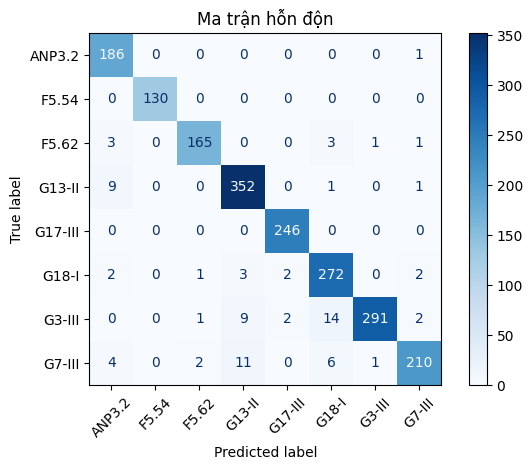


Chỉ số đánh giá chi tiết cho từng lớp:
Lớp ANP3.2:
  Precision: 0.9118
  Recall: 0.9947
  F1-Score: 0.9514
Lớp F5.54:
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
Lớp F5.62:
  Precision: 0.9763
  Recall: 0.9538
  F1-Score: 0.9649
Lớp G13-II:
  Precision: 0.9387
  Recall: 0.9697
  F1-Score: 0.9539
Lớp G17-III:
  Precision: 0.9840
  Recall: 1.0000
  F1-Score: 0.9919
Lớp G18-I:
  Precision: 0.9189
  Recall: 0.9645
  F1-Score: 0.9412
Lớp G3-III:
  Precision: 0.9932
  Recall: 0.9122
  F1-Score: 0.9510
Lớp G7-III:
  Precision: 0.9677
  Recall: 0.8974
  F1-Score: 0.9313

Macro-average Precision: 0.9613
Weighted-average Precision: 0.9590
Micro-average Precision: 0.9576


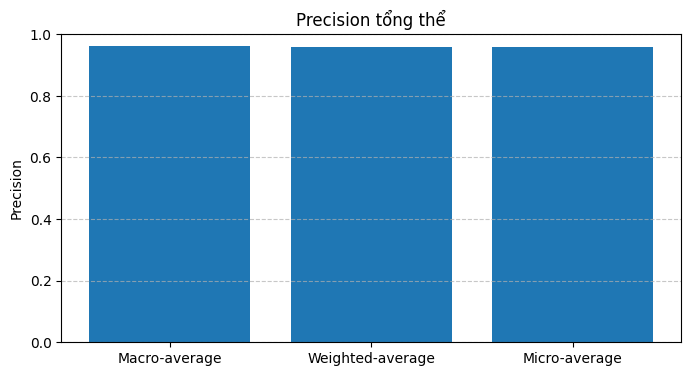

In [ ]:
import torch
import torchvision.models as models
import time
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load mô hình đã lưu
model.eval()

# Sử dụng GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Chuẩn bị dữ liệu
transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
   transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])


batch_size = 32  # Tăng batch_size để tăng tốc độ xử lý

test_dataset = datasets.ImageFolder("/content/test", transform=transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Lấy tên các lớp
class_names = test_dataset.classes
num_classes = len(class_names)

# Khởi tạo các biến để tính toán
all_preds = []
all_labels = []
total_time = 0
num_samples = 0

with torch.no_grad():  # Tắt gradient để tăng tốc
    for inputs, labels in test_loader:
        inputs = inputs.to(device)

        # Bắt đầu đo thời gian
        start_time = time.time()

        # Thực hiện inference
        outputs = model(inputs)

        # Đảm bảo tất cả các hoạt động GPU hoàn thành
        if device.type == "cuda":
            torch.cuda.synchronize()

        # Kết thúc đo thời gian
        end_time = time.time()

        # Cộng dồn thời gian
        total_time += (end_time - start_time)
        num_samples += inputs.size(0)

        # Lấy dự đoán
        _, preds = torch.max(outputs, 1)

        # Lưu nhãn và dự đoán để tính toán ma trận hỗn độn
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Tính thời gian trung bình cho mỗi mẫu
avg_time_per_sample = total_time / num_samples
print(f"Thời gian inference trung bình: {avg_time_per_sample:.4f} giây/mẫu")
print(f"FPS (frames per second): {1/avg_time_per_sample:.2f}")

# Tính ma trận hỗn độn
cm = confusion_matrix(all_labels, all_preds)

# Tính độ chính xác tổng thể
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Độ chính xác: {accuracy:.4f}")

# Vẽ ma trận hỗn độn
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Ma trận hỗn độn')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Tính các chỉ số đánh giá cho từng lớp
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# In các chỉ số đánh giá cho từng lớp
print("\nChỉ số đánh giá chi tiết cho từng lớp:")
for i in range(num_classes):
    print(f"Lớp {class_names[i]}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1_score[i]:.4f}")

# Sau phần tính precision, recall, f1_score cho từng lớp

# Tính precision tổng thể (macro-average)
macro_precision = np.mean(precision)
print(f"\nMacro-average Precision: {macro_precision:.4f}")

# Tính precision tổng thể (weighted-average)
weighted_precision = np.average(precision, weights=np.sum(cm, axis=1))
print(f"Weighted-average Precision: {weighted_precision:.4f}")

# Tính precision tổng thể (micro-average)
# Micro-average tính toán trực tiếp từ tổng số true positives và false positives
tp_sum = np.sum(np.diag(cm))
predicted_sum = np.sum(cm, axis=0)
micro_precision = tp_sum / np.sum(predicted_sum)
print(f"Micro-average Precision: {micro_precision:.4f}")

# Để thêm vào biểu đồ, có thể tạo biểu đồ mới cho precision tổng thể
plt.figure(figsize=(8, 4))
precision_metrics = [macro_precision, weighted_precision, micro_precision]
labels = ['Macro-average', 'Weighted-average', 'Micro-average']
plt.bar(labels, precision_metrics)
plt.ylabel('Precision')
plt.title('Precision tổng thể')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('overall_precision.png')
plt.show()

# **Lưu và tải mô hình về**

In [ ]:
from google.colab import files
import shutil

#Tạo đường dẫn và lưu mô hình
save_path = '/content/inception_V3.pth'
torch.save(model, save_path)
print(f"Mô hình đã được lưu tại: {save_path}")

#Zip mô hình và tải về máy
shutil.make_archive('/content/inception_V3.zip', 'zip', '/content/inception_V3.pth')
files.download('/content/inception_V3.zip')

Mô hình đã được lưu tại: /content/inception_V3.pth
